## Interpreting the Internals of a Small Language Model's Blocks

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
import json
import math
from pathlib import Path
from typing import Dict, Optional, Iterable, Sequence, Tuple, Type

In [ ]:
# | hide
# | output: false
from fastcore.test import *
from IPython import get_ipython
from manim import *
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm

Manim Community v0.17.3

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
    SubstringFrequencyAnalysis,
    top_nonzero_tokens
)
from transformer_experiments.common.utils import aggregate_by_string_key, DataWrapper
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.models.transformer import (
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer
)
from transformer_experiments.experiments.block_internals import (
    BlockInternalsAccessors,
    BlockInternalsExperiment,
    BatchedBlockInternalsExperiment,
    BlockInternalsAnalysis,
)
from transformer_experiments.experiments.logit_lens import LogitLens

## Motivation
Early this past summer, I trained a small language model. I then spent the rest of the summer taking it apart and trying to figure out how it works. This post is a summary of what I've learned so far. 

I started by watching [Andrej Karpathy](https://karpathy.ai/)'s excellent video, [Let's build GPT: from scratch, in code, spelled out](https://www.youtube.com/watch?v=kCc8FmEb1nY). In that video, he starts from a blank Jupyter notebook and, just under 2 hours later, ends with a functional transformer model (it's one of the best explanatory videos I've ever seen and highly recommend it). 

I want to make one thing super clear at the start: The code for the language model I trained came entirely from the video. It's Andrej's, not mine. I typed in the code by copying what I saw on the screen as I watched the video. For things that weren't clear onscreen, I referenced the [GitHub repo for the video](https://github.com/karpathy/ng-video-lecture) and the [nanoGPT repo](https://github.com/karpathy/nanoGPT). After getting it working, I made only minor changes to make it work with the rest of the code in/structure of this repository, resulting in [this implementation](https://github.com/spather/transformer-experiments/blob/master/nbs/models/transformer.ipynb). In summary: the core language model is Andrej Karpathy's work, not mine. The analysis and all the supporting code behind it is mine. I was of course inspired by many others and I'll cite their work in the relevant places. 

## The Model
The model I trained is a small, decoder-only [transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)). It’s trained on the [TinyShakespeare data set](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt) which contains 40,000 lines of Shakespeare’s plays. 

After about an hour of training on an A100 GPU, it is able to produce reasonable-looking fake Shakespearean text. Let’s spin it up and look at it in action:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file='../artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename='../artifacts/shakespeare-20231109.pt',
    dataset=ts,
    device=device,
)
print(f"device is {device}")
encoding_helpers = EncodingHelpers(tokenizer, device)

device is cpu


Given a prompt, the model predicts what the next tokens will be. Let's start with an easy task, giving it a prompt that surely it's seen before, `ROMEO:`, and ask it to generate 500 new tokens:

In [ ]:
_ = torch.manual_seed(1337) # Keep the output deterministic across runs
prompt = 'ROMEO:'
tokens = encoding_helpers.tokenize_string(prompt)
print(tokenizer.decode(m.generate(tokens, max_new_tokens=500)[0].tolist()))

ROMEO:
Thus he cannot cease to sun teach anon.

ROMEO:
Ay, but bid me strike! a gone night, a
man; a gentleman of break!

JULIET:
No, of the news, I am poeverty on;
therefore I knew no more than these than it.
These shields not must I have; means good night gnity.

ROMEO:
The most wife lies and holy foot.
3 KING RICHARD II:
Now to me, Tyrrel; and, justice! see how this sweet.

ROMEO:
It is much your time is the good nobleness charge
In looks, like praying below'd, wedding-grave's play.

Nurse:

JULIET


Don't try too hard to interpret it: meaning-wise, it's nonsense. But in terms of superficial structure, it looks Shakespearean:

* It's looks like a script for a play: a character name, followed by a colon, followed by a line of dialog.
* Most of the words are valid English words. It's important to note that in this model, the tokens are individual characters, not words. So it's making words up from characters and mostly getting it right. Though there are some notable exceptions like "sunse", "hoteful", and "insequents". But even these exceptions don't seem too far off from real words.
* Capitalization and punctuation are mostly correct: the first word of each line is capitalized, periods and other punctuation are used in plausible. Named characters ("ROMEO", "BUCKINGHAM") are in all-caps and unnamed characters ("Nurse") are not. But to be fair, all these character names appear in the training data, so that attribute is more likely a result of just copying what it's seen before vs understanding that pattern. 
* The language sounds archaic, using words like "Thou", "Nay", "yond", and 'dancest'. It's noteable tht "dancest" does not actually appear in the training data, so it's not just copying words it's seen before. 

When given a prompt it hasn't seen before, it still does a reasonable job:

In [ ]:
_ = torch.manual_seed(1337) # Keep the output deterministic across runs
prompt = 'Hello'
tokens = encoding_helpers.tokenize_string(prompt)
print(tokenizer.decode(m.generate(tokens, max_new_tokens=100)[0].tolist()))

Hellow, stands, dear Edward's sunshine
But far and this powerful to state;
That insent to take him for an


"Hello" doesn't appear anywhere in the text, but you can see how it got to "Hellows" given that "fellow", "yellow", and "mellow" do. Even a completely gibberish prompt, like `adxed3dd`, it's able to recover and produce something reasonable looking: 

In [ ]:
_ = torch.manual_seed(1337) # Keep the output deterministic across runs
prompt = 'adxed3dd'
tokens = encoding_helpers.tokenize_string(prompt)
print(tokenizer.decode(m.generate(tokens, max_new_tokens=100)[0].tolist()))

adxed3dds
Clean thee weary on their age and bones.

KING RICHARD III:
To tell, make nothing of your grace an


## Model Architecture

In [ ]:
# | echo: false
def render_final_frame(scene_class: Type, quality: str = 'ql'):
    get_ipython().run_cell_magic(
        'manim',
        f'-v WARNING --progress_bar None -{quality} -s --disable_caching {scene_class.__name__}',
        '# dummy',
    )

Here is a high-level diagram of the model's architecture:

In [ ]:
# | code-fold: true
# | code-summary: Drawing code for architecture diagram

class ArchDiagram(Scene):
    def construct(self):
        prompt = 'ROMEO:'
        tokens = Table(
            [[str(t) for t in tokenizer.encode(prompt)]],
            include_outer_lines=True,
        ).scale(0.25)
        tokens = VGroup(
            Text('Input tokens').scale(0.4).next_to(tokens, UP, buff=0.1),
            tokens,
        )

        token_emb = m.token_embedding_table(encoding_helpers.tokenize_string(prompt))
        token_emb = MobjectTable(
            [[Text(f'{x:.1f}') for x in token_emb[0, :, row]] for row in range(0, 2)]
            + [[Text('...').rotate(PI/2) for _ in prompt]]
            + [
                [Text(f'{x:.1f}') for x in token_emb[0, :, row]]
                for row in range(n_embed - 2, n_embed)
            ],
            include_outer_lines=True,
        ).scale(0.25)

        pos_emb = m.position_embedding_table(
            torch.arange(0, len(prompt), device=device)
        )
        pos_emb = MobjectTable(
            [[Text(f'{x:.1f}') for x in pos_emb[:, row]] for row in range(0, 2)]
            + [[Text('...').rotate(PI/2) for _ in prompt]]
            + [
                [Text(f'{x:.1f}') for x in pos_emb[:, row]]
                for row in range(n_embed - 2, n_embed)
            ],
            include_outer_lines=True,
        ).scale(0.25)

        embs = VGroup(
            token_emb,
            pos_emb,
        ).arrange(RIGHT, buff=2)

        embs = VGroup(
            tokens,
            embs,
        ).arrange(DOWN, buff=0.5)

        emb_labels = VGroup(
            Text('Token embeddings')
            .scale(0.4)
            .next_to(token_emb, DOWN, buff=0.1)
            .align_to(token_emb, LEFT),
            Text('Position embeddings')
            .scale(0.4)
            .next_to(pos_emb, DOWN, buff=0.1)
            .align_to(pos_emb, RIGHT),
        )

        blocks1_2 = [Rectangle(height=0.4, width=3) for _ in range(2)]
        vert_ellipsis = VGroup(
            *[Circle(radius=0.025, color=WHITE) for _ in range(3)],
        ).arrange(direction=DOWN, buff=0.1)
        block6 = Rectangle(height=0.4, width=3)
        blocks = VGroup(
            *blocks1_2,
            vert_ellipsis,
            block6,
        ).arrange(DOWN, buff=0.1)

        empty_rect = Rectangle(height=0.4, width=3, color=BLACK)

        out_blocks = [Rectangle(height=0.4, width=3) for _ in range(3)]

        arch = VGroup(
            embs,
            emb_labels,
            blocks,
            empty_rect,
            *out_blocks,
            empty_rect.copy()
        ).arrange(DOWN, buff=0.1)
        self.add(arch)

        # Add annotations

        # Lines and arrows between tokens and embedding tables
        left_line = Line(start=tokens[1].get_left(), end=(tokens[1].get_left() * [0., 1., 0.]) + (token_emb.get_center() * [1., 0., 0.]))
        self.add(left_line)
        left_arrow_down = Arrow(max_tip_length_to_length_ratio=0.15)
        left_arrow_down.put_start_and_end_on(
            start=left_line.get_left(),
            end=left_line.get_left() * [1., 0., 0.] + token_emb.get_top() * [0., 1., 0.],
        )
        self.add(left_arrow_down)

        right_line = Line(start=tokens[1].get_right(), end=(tokens[1].get_right() * [0., 1., 0.]) + (pos_emb.get_center() * [1., 0., 0.]))
        self.add(right_line)
        right_arrow_down = Arrow(max_tip_length_to_length_ratio=0.15)
        right_arrow_down.put_start_and_end_on(
            start=right_line.get_right(),
            end=right_line.get_right() * [1., 0., 0.] + pos_emb.get_top() * [0., 1., 0.],
        )
        self.add(right_arrow_down)

        # Circle with the plus between the embedding tables
        circle = (
            Circle(radius=0.4, color=WHITE)
            .move_to((token_emb.get_right() + pos_emb.get_left()) / 2)
        )
        self.add(circle)
        plus = Text('+').move_to(circle.get_center())
        self.add(plus)

        # Arrows from embedding tables to circled plus
        right_arrow = Arrow(max_tip_length_to_length_ratio=0.15)
        right_arrow.put_start_and_end_on(
            start=token_emb.get_right(),
            end=circle.get_left()
        )
        self.add(right_arrow)

        left_arrow = Arrow(max_tip_length_to_length_ratio=0.15)
        left_arrow.put_start_and_end_on(
            start=pos_emb.get_left(),
            end=circle.get_right()
        )
        self.add(left_arrow)

        # Arrow down to the first block
        down_arrow = Arrow(max_tip_length_to_length_ratio=0.15)
        down_arrow.put_start_and_end_on(
            start=circle.get_bottom(),
            end=blocks1_2[0].get_top(),
        )
        self.add(down_arrow)

        # Block labels
        blocks1_2_labels = [Text(f'Block {b+1}').move_to(blocks1_2[b].get_center()).scale(0.4) for b in range(2)]
        self.add(*blocks1_2_labels)
        block6_label = Text('Block 6').move_to(block6.get_center()).scale(0.4)
        self.add(block6_label)

        # Output blocks labels
        labels = ['Layer norm', 'Linear', 'Softmax']
        out_block_labels = [Text(f'{l}').move_to(out_blocks[b].get_center()).scale(0.4) for b, l in enumerate(labels)]
        self.add(*out_block_labels)

        # Arrow between last block and output blocks
        out_block_arrow = Arrow(max_tip_length_to_length_ratio=0.08)
        out_block_arrow.put_start_and_end_on(
            start=block6.get_bottom(),
            end=out_blocks[0].get_top(),
        )
        self.add(out_block_arrow)

        # Text at the bottom
        out_prob_text = Text('Output probabilities').scale(0.4).next_to(out_blocks[-1], DOWN, buff=0.5)
        self.add(out_prob_text)

        # Arrow between softmax and output probs
        out_prob_arrow = Arrow(max_tip_length_to_length_ratio=0.08)
        out_prob_arrow.put_start_and_end_on(
            start=out_blocks[-1].get_bottom(),
            end=out_prob_text.get_top(),
        )
        self.add(out_prob_arrow)

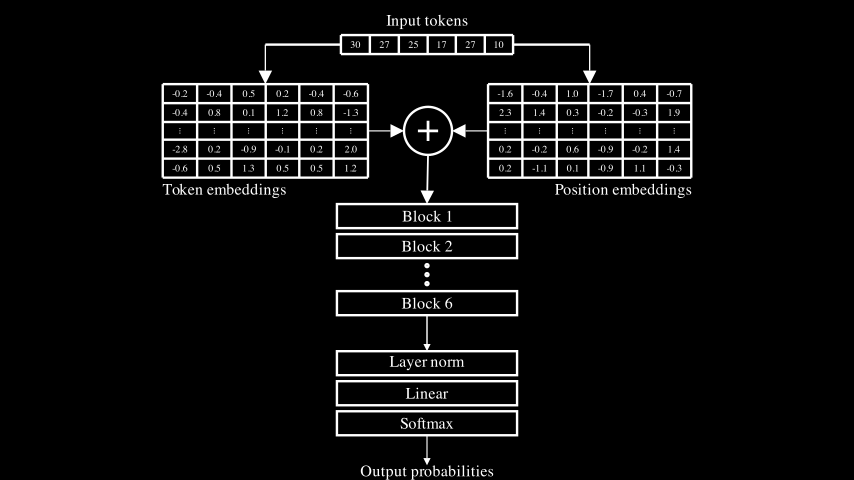

In [ ]:
# | echo: false
render_final_frame(ArchDiagram)

Input tokens are converted to embeddings via a two-step process. First, the tokens themselves are converted to token embeddings. Then positional embeddings are added to the token embeddings, producing the final embeddings that are fed into the stack of transformer blocks. We'll look into the internal structure of a block in more detail next. The output of one block becomes the input to the next block. 

The output of the final block goes through a layer norm, and then a linear layer that converts from the embedding space to a vector of logits of the vocabulary size. The final softmax layer turns the logits into probabilities.

Each of the transformer blocks is identical in architecture but has potentially different learned parameters. Inside each block are two sub-layers: a multi-head self-attention layer and a feed-forward layer, as shown in the following diagram:

In [ ]:
# | code-fold: true
# | code-summary: Drawing code for block internals architecture diagram


class BlockArchDiagram(Scene):
    def construct(self):
        input_emb = Rectangle(height=0.4, width=3)
        input_emb_label = (
            Text('Input embedding').move_to(input_emb.get_center()).scale(0.4)
        )
        input_emb = VGroup(input_emb, input_emb_label)

        ln1 = Rectangle(height=0.4, width=3)
        ln1_label = Text('Layer norm').move_to(ln1.get_center()).scale(0.4)
        ln1 = VGroup(ln1, ln1_label)

        sa = Rectangle(height=0.4, width=3)
        sa_label = Text('Multi-head self-attention').move_to(sa.get_center()).scale(0.4)
        sa = VGroup(sa, sa_label)

        stack1 = VGroup(ln1, sa).arrange(DOWN, buff=0.5)

        first_plus = self.circled_plus(radius=0.3)

        ln2 = Rectangle(height=0.4, width=3)
        ln2_label = Text('Layer norm').move_to(ln2.get_center()).scale(0.4)
        ln2 = VGroup(ln2, ln2_label)

        ffwd = Rectangle(height=0.4, width=3)
        ffwd_label = Text('Feed forward').move_to(ffwd.get_center()).scale(0.4)
        ffwd = VGroup(ffwd, ffwd_label)

        stack2 = VGroup(ln2, ffwd).arrange(DOWN, buff=0.5)

        empty_rect = Rectangle(height=0.2, width=3, color=BLACK)

        second_plus = self.circled_plus(radius=0.3)

        self.add(
            VGroup(
                empty_rect,
                input_emb,
                stack1,
                first_plus,
                empty_rect.copy(),
                stack2,
                second_plus,
                empty_rect.copy(),
            ).arrange(DOWN, buff=0.5)
        )
        stack1.shift(LEFT * 2)
        stack2.shift(LEFT * 2)

        # Add annotations

        arrow_stroke_width = 2.0
        # Arrow from input emb to ln1
        self.add(
            self.arrow_via_points(
                [
                    input_emb.get_left(),
                    ln1.get_top() * [1.0, 0.0, 0.0]
                    + input_emb.get_left() * [0.0, 1.0, 0.0],
                    ln1.get_top(),
                ],
                stroke_width=arrow_stroke_width,
            )
        )

        # Arrow from ln1 to sa
        self.add(
            self.arrow_via_points(
                [
                    ln1.get_bottom(),
                    sa.get_top(),
                ],
                stroke_width=2 * arrow_stroke_width,
            )
        )

        # Arrow from sa to first plus
        self.add(
            self.arrow_via_points(
                [
                    sa.get_bottom(),
                    sa.get_bottom() * [1.0, 0.0, 0.0]
                    + first_plus.get_left() * [0.0, 1.0, 0.0],
                    first_plus.get_left(),
                ],
                stroke_width=arrow_stroke_width,
            )
        )

        # Arrow from input emb to circled plus
        self.add(
            self.arrow_via_points(
                [
                    input_emb.get_right(),
                    ln1.get_top() * [-1.0, 0.0, 0.0]
                    + input_emb.get_right() * [0.0, 1.0, 0.0],
                    ln1.get_top() * [-1.0, 0.0, 0.0]
                    + first_plus.get_right() * [0.0, 1.0, 0.0],
                    first_plus.get_right(),
                ],
                stroke_width=arrow_stroke_width,
            )
        )

        # Arrow from first plus to ln2
        self.add(
            self.arrow_via_points(
                [
                    first_plus.get_bottom(),
                    first_plus.get_bottom()
                    + (ln2.get_top() - first_plus.get_bottom()) * [0.0, 0.5, 0.0],
                    ln2.get_top()
                    - (ln2.get_top() - first_plus.get_bottom()) * [0.0, 0.5, 0.0],
                    ln2.get_top(),
                ],
                stroke_width=arrow_stroke_width,
            )
        )

        # Arrow from ln2 to ffwd
        ln2_ffwd_arrow = Arrow(max_tip_length_to_length_ratio=0.08)
        ln2_ffwd_arrow.put_start_and_end_on(
            start=ln2.get_bottom(),
            end=ffwd.get_top(),
        )
        self.add(ln2_ffwd_arrow)

        # Arrow from ffwd to second plus
        self.add(
            self.arrow_via_points(
                [
                    ffwd.get_bottom(),
                    ffwd.get_bottom() * [1.0, 0.0, 0.0]
                    + second_plus.get_left() * [0.0, 1.0, 0.0],
                    second_plus.get_left(),
                ],
                stroke_width=arrow_stroke_width,
            )
        )

        # Arrow from first plus to second plus
        self.add(
            self.arrow_via_points(
                [
                    first_plus.get_bottom()
                    + (ln2.get_top() - first_plus.get_bottom()) * [0.0, 0.5, 0.0],
                    second_plus.get_top(),
                ],
                stroke_width=2 * arrow_stroke_width,
            )
        )

        # Arrow from second plus to output
        self.add(
            self.arrow_via_points(
                [
                    second_plus.get_bottom(),
                    second_plus.get_bottom() + DOWN * 0.4,
                ],
                stroke_width=2 * arrow_stroke_width,
            )
        )

    def arrow_via_points(self, points: Iterable[np.ndarray], stroke_width: float = 2.0):
        assert (
            len(points) >= 2
        ), 'Must provide at least two points to draw an arrow between'

        lines = VGroup()
        if len(points) > 2:
            # Draw lines up to the the second to last point
            lines.add(
                *[
                    Line(start=points[i], end=points[i + 1], stroke_width=stroke_width)
                    for i in range(len(points) - 1)
                ]
            )

        # Draw the final arrow
        arrow_length = np.linalg.norm(points[-1] - points[-2])
        arrow = Arrow(
            max_tip_length_to_length_ratio=0.08,
            max_stroke_width_to_length_ratio=stroke_width / arrow_length,
        )
        arrow.put_start_and_end_on(
            start=points[-2],
            end=points[-1],
        )
        arrow.set_stroke(
            width=stroke_width / 2
        )  # I don't know why but to get the width right I need to divide by 2
        lines.add(arrow)
        return lines

    def circled_plus(self, radius: float = 0.4):
        circle = Circle(radius=radius, color=WHITE)
        plus = Text('+').move_to(circle.get_center())
        return VGroup(circle, plus)

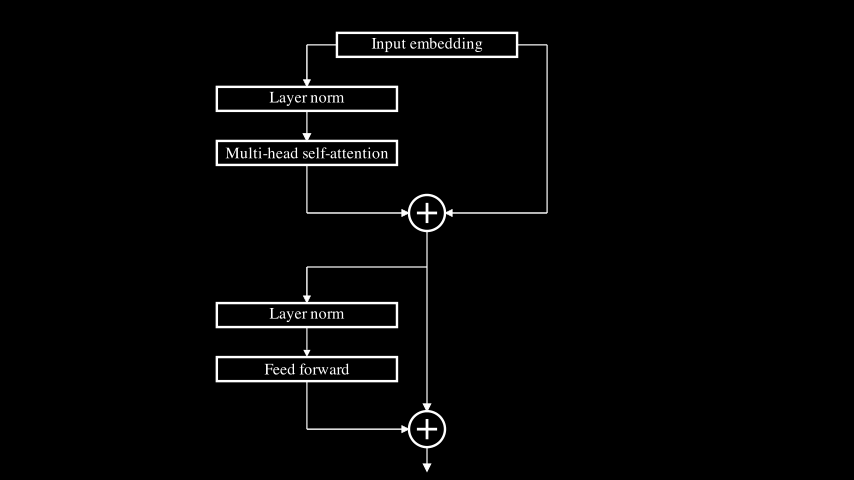

In [ ]:
# | echo: false
render_final_frame(BlockArchDiagram)

The embedding flowing into the block goes into a layer norm, then into the self-attention layer. The output of is added to the original embedding (implementing a skip connection). The result of the skip connection goes into another layer norm, then into the feed-forward layer. The output of the feed-forward layer is added to the earlier sum of the multi-head attention and input embedding (another skip connection). This final sum is the output of the block. 

In code, the logic of the block looks like:

```python
class Block(nn.Module):
    """One transformer block"""

    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1  = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)


    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # The `x +` part is a skip connection
        x = x + self.ffwd(self.ln2(x)) # The `x +` part is a skip connection

        return x
```

I'll conclude this short summary of the model architecture with a few specs:

* Vocabulary size: 65 (just the characters in the TinyShakespeare dataset)
* Embedding size (`n_embed`): 384
* Number of transformer blocks (`n_layer`): 6
* Number of attention heads (`n_head`): 6
* Context window size (`block_size`): 256

I'm not going to go too much further into the details of the model architecture. If you want to learn more, I highly recommend watching [Andrej's video](https://www.youtube.com/watch?v=kCc8FmEb1nY).

## Following a prompt through the model

To see what the model is doing, let's start with a prompt that produces some interesting output. To begin, we'll use the prompt:

> my most gr

This phrase appears twice in the training set:

```
Line 22488: Three, my most gracious lord.
...
Line 34007: O my most gracious lord,
```

We can peek at what the probabilities the model generates for the next token:

In [ ]:
prompt = 'my most gr'
tokens = encoding_helpers.tokenize_string(prompt)
logits, _ = m(tokens)
logits = LogitsWrapper(logits.detach(), tokenizer)
for token, prob in logits.topk_tokens(k=10)[0][-1]:
    print(f'{repr(token)} {prob:.3f}')

'a' 0.737
'e' 0.198
'i' 0.036
'o' 0.026
'u' 0.002
'r' 0.001
'h' 0.000
'y' 0.000
's' 0.000
'l' 0.000


The `a`, which appeared next to the phrase in the training set is the top token, but it only has a 46% probability. The model might pick `e` with 35% probability, or `o` or `i` with 10% probability. Notice that the top 5 characters are vowels and the 6th is `y`, which is vowel-adjacent. The model has learned that this phrase should be followed by a vowel, which seems very reasonable. 

Let's see how the choice of next token plays out in practice, but runningthe model 10 times:

In [ ]:
tokens = encoding_helpers.tokenize_string(prompt)
n_runs = 10
torch.manual_seed(1337)
for _ in range(n_runs):
    print(repr(tokenizer.decode(m.generate(tokens, max_new_tokens=5)[0].tolist())))

'my most gravell'
'my most grandac'
'my most grade.\n'
'my most graciou'
'my most greatne'
'my most grandal'
'my most greatne'
'my most graciou'
'my most grandam'
'my most grandal'


We see some repetition, but also some variation and all the variants seem reasonable. The model is clearly not just copying the training set. 

How is the model coming up with it's predictions? I built a view into how the prompt progresses through the model, inspired by some ideas that came from the excellent post [interpreting GPT: the logit lens](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens). 

todo: explain why the intermediate embeddings can be projected out as logits

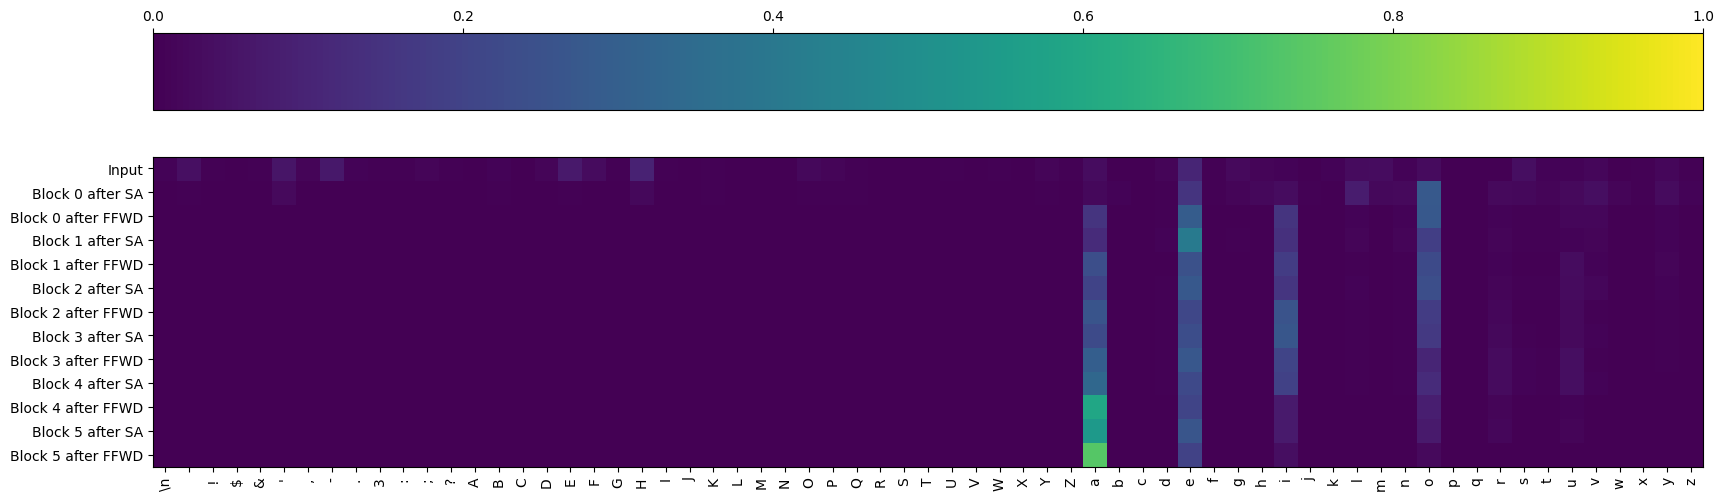

In [ ]:
accessors = TransformerAccessors(m, device=device)
bia = BlockInternalsAnalysis(accessors, encoding_helpers, prompt=prompt)
bia.plot()

Let's look at just the columns for the top tokens (the vowels plus `y`):

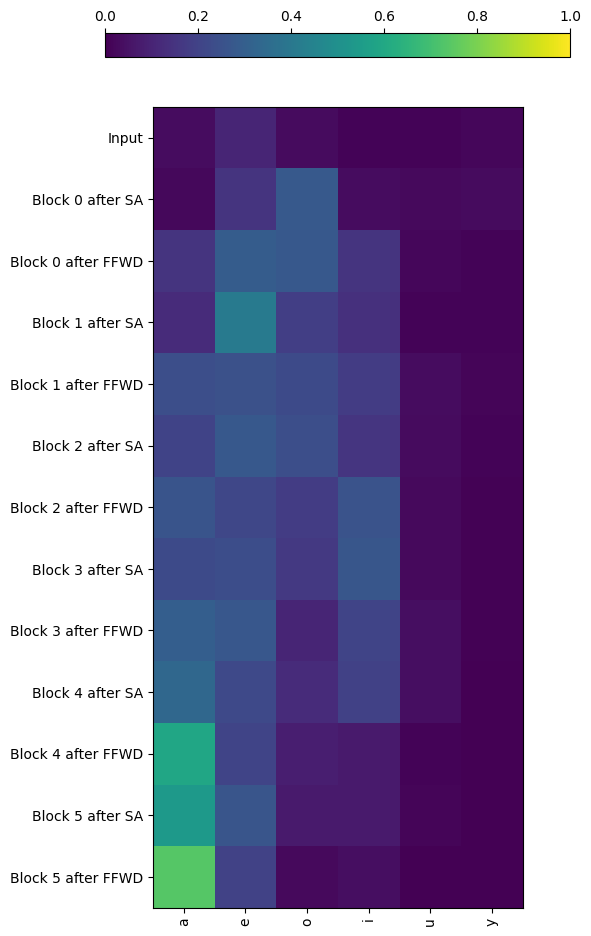

In [ ]:
bia.plot_subset(cols = [tokenizer.stoi[c] for c in 'aeoiuy'])